In [1]:
# !pip install --upgrade transformers
# !pip install --upgrade transformers accelerate peft bitsandbytes
# !pip install datasets
# !pip install scikit-learn
# !pip install evaluate
# !pip install wandb
# !pip install matplotlib
# !pip install sentencepiece

In [2]:
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
import evaluate
import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
labeled_final = load_dataset("glue", "mrpc")
labeled_final
# train = dataset["train"]
# valid = dataset["validation"]


DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [4]:
# Define a function to remove noise
def remove_noise(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove special patterns like "< .SPX >", "< .IXIC >"
    text = re.sub(r'< \.[A-Z]+ >', '', text)

    # Remove ellipsis (...)
    text = re.sub(r'\.\s*\.\s*\.+', ' ', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters like "â€™", "Â½", "Â£", etc.
    text = re.sub(r'[â€™Â½Â£]', '', text)

    # Remove single alphabets (e.g., "C")
    text = re.sub(r'\b\w\b', '', text)

    # Remove equal (=) sign at the end
    text = re.sub(r'=$', '', text)

    # Remove double hyphens (--)
    text = re.sub(r'--+', '', text)

    # Remove unwanted quotes
    text = re.sub(r'["“”]', '', text)

    # Fix short words with apostrophes (e.g., "'re" -> "are")
    text = re.sub(r"\s+'re\b", " are", text)
    text = re.sub(r"\b're\b", "are", text)
    text = re.sub(r"\b've\b", "have", text)
    text = re.sub(r"\b'll\b", "will", text)
    text = re.sub(r"\b'd\b", "would", text)
    text = re.sub(r"\b'm\b", "am", text)
    text = re.sub(r"\b's\b", "is", text)
    text = re.sub(r"\b'n\b", "and", text)
    text = text.lower()

    return text

def remove_noise_batch(examples):
    examples["cleaned_sentence1"] = [remove_noise(sentence) for sentence in examples["sentence1"]]
    examples["cleaned_sentence2"] = [remove_noise(sentence) for sentence in examples["sentence2"]]
    return examples


In [5]:
train_dataset = labeled_final["train"].map(remove_noise_batch, batched=True)
valid_dataset = labeled_final["validation"].map(remove_noise_batch, batched=True)
test_dataset = labeled_final["test"].map(remove_noise_batch, batched=True)

In [6]:
train = train_dataset
valid = valid_dataset
test = test_dataset

In [7]:
# Model and tokenizer
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Ensure tokenizer has a pad_token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [8]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    device_map="auto",
)



# from transformers import RobertaConfig, RobertaForSequenceClassification

# # Custom configuration
# config = RobertaConfig.from_pretrained(
#     model_name,
#     hidden_dropout_prob=0.3,  # Dropout for hidden layers
#     attention_probs_dropout_prob=0.3,  # Dropout for attention layers
#     num_labels=2,  # Binary classification for MRPC
# )

# # Load model with custom configuration
# model = RobertaForSequenceClassification.from_pretrained(model_name, config=config)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Set pad_token_id in model configuration
model.config.pad_token_id = tokenizer.pad_token_id

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["cleaned_sentence1"],
        examples["cleaned_sentence2"],
        padding=True,
        truncation=True,
        max_length=128,
    )

tokenized_train_dataset = train.map(tokenize_function, batched=True)
tokenized_valid_dataset = valid.map(tokenize_function, batched=True)
tokenized_test_dataset = test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [10]:
tokenized_test_dataset

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx', 'cleaned_sentence1', 'cleaned_sentence2', 'input_ids', 'attention_mask'],
    num_rows: 1725
})

In [11]:
# Keep only the necessary features
tokenized_train_dataset = tokenized_train_dataset.map(
    lambda examples: {
        "input_ids": examples["input_ids"],
        "attention_mask": examples["attention_mask"],
        "labels": examples["label"]
    },
    remove_columns=["idx", "sentence1", "sentence2", "label",'cleaned_sentence1', 'cleaned_sentence2']
)

tokenized_valid_dataset = tokenized_valid_dataset.map(
    lambda examples: {
        "input_ids": examples["input_ids"],
        "attention_mask": examples["attention_mask"],
        "labels": examples["label"]
    },
    remove_columns=["idx", "sentence1", "sentence2", "label",'cleaned_sentence1', 'cleaned_sentence2']
)

tokenized_test_dataset = tokenized_test_dataset.map(
    lambda examples: {
        "input_ids": examples["input_ids"],
        #"attention_mask": examples["attention_mask"],
        "labels": examples["label"]
    },
    remove_columns=["idx", "sentence1", "sentence2", "label",'cleaned_sentence1', 'cleaned_sentence2','attention_mask']
)


# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [12]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [13]:

# Metrics
#metric = evaluate.load("glue", "mrpc")

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     results = metric.compute(predictions=predictions, references=labels)

#     accuracy = results["accuracy"]
#     f1 = results["f1"]
#     precision = results.get("precision", None)
#     recall = results.get("recall", None)

#     return {
#         "accuracy": accuracy,
#         "f1": f1,
#         "precision": precision,
#         "recall": recall,
#     }
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get the class with the highest score

    # Calculate accuracy, precision, recall, and F1
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [14]:
# #model.config.use_cache = False
# # Training arguments
# training_args = TrainingArguments(
#     output_dir="./results_modernbert_mrpc",
#     learning_rate=8e-5,  # You can adjust this
#     per_device_train_batch_size=32,  # You can adjust this
#     per_device_eval_batch_size=32,  # You can adjust this
#     num_train_epochs=5,  # You can adjust this
#     weight_decay=0.001,
#     warmup_steps=100,
#     logging_dir="./logs_modernberta_mrpc",
#     logging_steps=10,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     save_total_limit=2,
#     load_best_model_at_end=True,
#     fp16=True,
#     gradient_checkpointing=True,
#     max_grad_norm=1.0,
# )

train_bsz, val_bsz = 32, 32
lr = 8e-5
betas = (0.9, 0.98)
n_epochs = 2
eps = 1e-6
wd = 8e-6

training_args = TrainingArguments(
    output_dir="./results_modernbert_mrpc",
    learning_rate=lr,
    per_device_train_batch_size=train_bsz,
    per_device_eval_batch_size=val_bsz,
    num_train_epochs=n_epochs,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    adam_beta1=betas[0],
    adam_beta2=betas[1],
    adam_epsilon=eps,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    bf16=True,
    bf16_full_eval=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_valid_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# Train the model
training_history = trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,nan,0.316176,0.000000,0.000000,0.000000
2,0.000000,nan,0.316176,0.000000,0.000000,0.000000


{'eval_loss': nan, 'eval_accuracy': 0.3161764705882353, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 1.3154, 'eval_samples_per_second': 310.165, 'eval_steps_per_second': 9.883, 'epoch': 2.0}


In [15]:
training_history

TrainOutput(global_step=230, training_loss=0.0, metrics={'train_runtime': 97.0995, 'train_samples_per_second': 75.551, 'train_steps_per_second': 2.369, 'total_flos': 493124522257248.0, 'train_loss': 0.0, 'epoch': 2.0})

ValueError: x and y must have same first dimension, but have shapes (2,) and (3,)

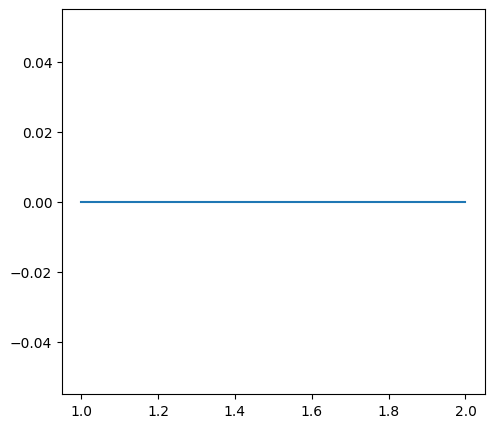

In [16]:
import matplotlib.pyplot as plt

# Extract data from log_history
log_history = trainer.state.log_history

# Initialize lists to store data
epochs = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Parse log_history
for log in log_history:
    if 'loss' in log and 'epoch' in log:  # Training step
        epochs.append(log['epoch'])
        train_losses.append(log['loss'])
        if 'accuracy' in log:
            train_accuracies.append(log['accuracy'])
    elif 'eval_loss' in log and 'epoch' in log:  # Validation step
        val_losses.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            val_accuracies.append(log['eval_accuracy'])

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(val_losses)], val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
#plt.plot(epochs[:len(train_accuracies)], train_accuracies, label='Training Accuracy')
plt.plot(epochs[:len(val_accuracies)], val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(' ValidationAccuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predictions = trainer.predict(tokenized_test_dataset)
predictions

In [ ]:
# Get the logits
logits = predictions.predictions

# Convert logits to predicted class labels
predicted_labels = np.argmax(logits, axis=-1)

# Get the actual labels from the test dataset (if available)
actual_labels = tokenized_test_dataset['labels']

accuracy = accuracy_score(actual_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='binary')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-score: {f1}")